![IN-CORE_resilience-logo.png](images/IN-CORE_resilience-logo.png)

# Galveston Testbed (previous version)

# IN-CORE Flowchart - Galveston
This notebook uses the Galveston testbed to demonstrate the following components of the IN-CORE flowchart.

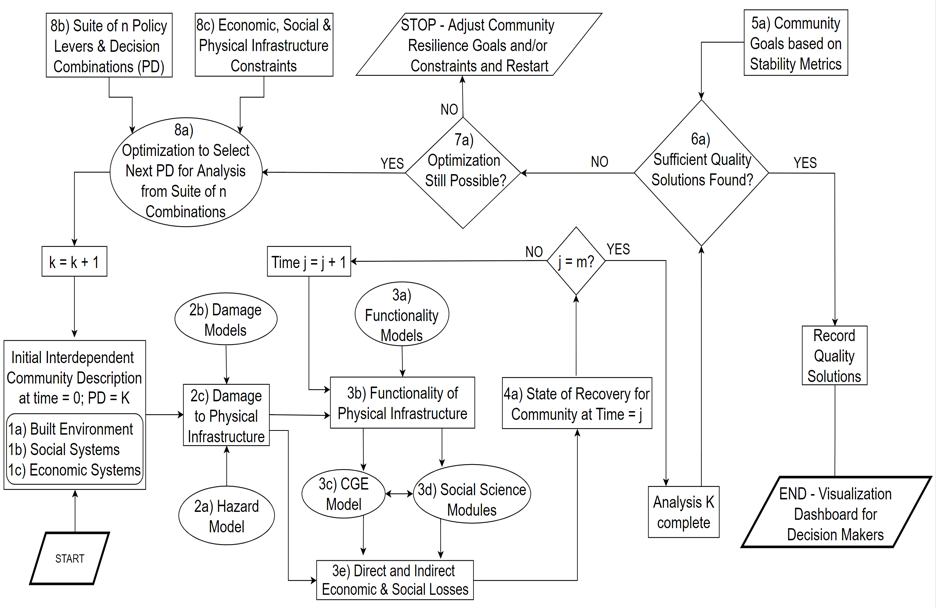

# Background
The **Galveston Testbed** is an ongoing effort of the Center to test model chaining an integration across coupled systems. The current Galveston Testbed and Jupyter notebooks released with IN-CORE focus on **Galveston Island** as a barrier island exposed to hurricane hazards. Our ongoing work extends this analysis to Galveston County, further exploring the interplay between economic activity and recovery efforts between the mainland and the island. As shown in the following figure, Galveston County is located in the southeastern part of Texas, along the Gulf Coast adjacent to Galveston Bay.

Galveston Island is located in southern Galveston County with a total length of 43.5 km and a width of 4.8 km. The Island is surrounded by West Bay from the west, the Gulf of Mexico from the south and east, and Galveston Bay in the North. The Galveston Island is connected to the rest of Galveston County by interstate highway I-45. Based on the 2015 county parcel data the total number of buildings within Galveston County was 172,534 buildings with 29,541 buildings located on Galveston Island. In 2010, the total population living on Galveston Island was 48,726 people with a racial/ethnic composition of 46% non-Hispanic White, 18% non-Hispanic Black, and 31% Hispanic. Galveston, Texas has a long history with hurricanes including the Great Galveston Hurricane in 1900 which is considered the deadliest natural disaster in U.S. history. More recently, the island was affected by Hurricane Ike (2008) and Hurricane Harvey (2017), each posing unique challenges in terms of coastal multi-hazards and recovery challenges, and with billions of dollars in economic impacts. 

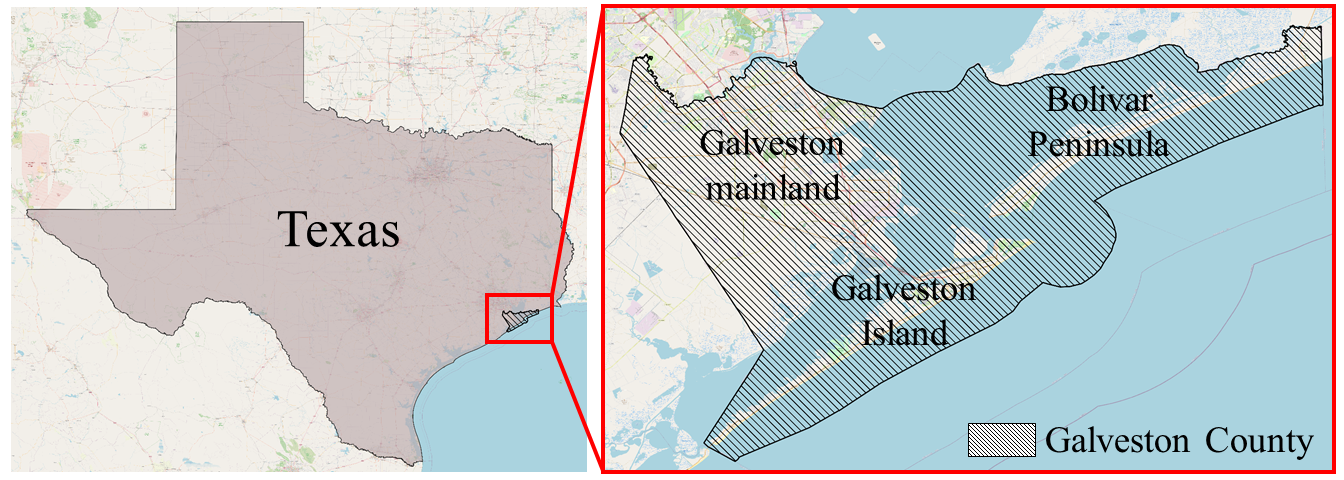

# General info

Some of the main objectives of the Galveston Testbed include:

1. Investigate the multi-hazard surge, wave, inundation, and wind hazards in coastal settings.
2. Consider interdependent infrastructure systems including buildings, transportation, and power.
3. Leverage historical social-science data, informing population dislocation and recovery modeling.
4. Evaluate hybrid metrics of community resilience, such as those that require coupled modeling between social and physical systems.

More information about the testbed and the field study can be found in this publication:
1. Fereshtehnejad, E., Gidaris, I., Rosenheim, N., Tomiczek, T., Padgett, J. E., Cox, D. T., ... & Gillis Peacock, W. (2021). Probabilistic risk assessment of coupled natural-physical-social systems: cascading impact of hurricane-induced damages to civil infrastructure in Galveston, Texas. Natural Hazards Review, 22(3), 04021013.

The current notebook is a WORK-IN-PROGRESS that consists of the following modules:
1. Community Description with Housing Unit Allocation  
2. Hazard Model: Flood Surge, Wave, and Inundation Modeling with Building Damage
3. Functionality Models: Phycial Infrastructure and Population Dislocation
4. Recovery Models with Household-Level Housing Recovery Analysis
6. Policy Lever Analysis

The models used in this testbed come from:
1. Nofal, O. M., Van De Lindt, J. W., Do, T. Q., Yan, G., Hamideh, S., Cox, D. T., & Dietrich, J. C. (2021). Methodology for Regional Multihazard Hurricane Damage and Risk Assessment. Journal of Structural Engineering, 147(11), 04021185.

2. Darestani, Y. M., Webb, B., Padgett, J. E., Pennison, G., & Fereshtehnejad, E. (2021). Fragility Analysis of Coastal Roadways and Performance Assessment of Coastal Transportation Systems Subjected to Storm Hazards. Journal of Performance of Constructed Facilities, 35(6), 04021088.

3. Darestani, Y., Padgett, J., & Shafieezadeh, A. (2022). Parametrized Wind–Surge–Wave Fragility Functions for Wood Utility Poles. Journal of Structural Engineering, 148(6), 04022057.

1. Rosenheim, N., Guidotti, R., Gardoni, P., & Peacock, W. G. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure, 6(6), 385-401.

2. Sutley, E. J., & Hamideh, S. (2020). Postdisaster housing stages: a markov chain approach to model sequences and duration based on social vulnerability. Risk Analysis, 40(12), 2675-2695.

Prerequisites:
The following packages are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**.


| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>1.7.0 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| pyIncore_viz | =>1.5.0 | see: https://incore.ncsa.illinois.edu/doc/pyincore_viz/index.html |

# Start

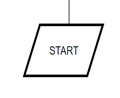

The following codes are preparing the analysis by checking versions and connecting to IN-CORE web service. Also, all of the necessary pyIncore analyses are being imported. In this analysis, the following pyIncore analyses are utilized:
* **Building damage**: Computes building damage based on a particular hazard (hurricane in this testbed).
* **Building functionality**: Calculates building functionality probabilities.
* **Housing unit allocation**: Sets up a detailed critical infrastructure inventory with housing unit level characteristics. 
* **Population dislocation**: Computes population dislocation based on a particular hazard (hurricane in this testbed).
* **Household-level housing sequential recovery**: Computes the series of household recovery states given a population dislocation dataset.
* **Policy Lever Demonstration**: Modify Building Inventory to reduce building damage.

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.combinedwindwavesurgebuildingdamage import CombinedWindWaveSurgeBuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability

In [9]:
# Functions for visualizing the population data results as tables
from pyincore_viz.analysis.popresultstable import PopResultsTable as poptable

In [10]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:41:22) [MSC v.1929 64 bit (AMD64)]
pandas version:  1.5.2
numpy version:  1.24.1


In [11]:
# Check working directory - good practice for relative path access
os.getcwd()

'C:\\Users\\ka50\\Box\\Rice\\Software_Projects\\Pycharm\\IN-CORE_Galveston\\jupyter_book\\notebooks'

In [12]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
# client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.8.0


# 1) Initial community description

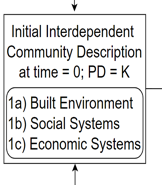

Step 1 in IN-CORE is to establish initial community description at time 0 and with policy levers and decision combinations (PD) set to K (baseline case). The community description includes three parts including **1a) Built Environment**, **1b) Social Systems**, and **1c) Economic Systems**.

## 1a) Built Environment
The Galveston testbed consists of five infrastructure systems as buildings, transportation network, electric power transmission and distribution network, water/wastewater network, and critical facilities. Each infrastructure system may be composed of different infrastructure components. For example, the transportation network consists of bridges and roadways. The infrastructure systems and components are shown below along with their IN-CORE GUID.

| No. | Infrastructure System | Infrastructure Component | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Buildings | - | 63053ddaf5438e1f8c517fed| Ref. |
| 2 | Transportation network | Bridges | 60620320be94522d1cb9f7f0| Ref. |
| - | Transportation network | Roadways | 5f15d04f33b2700c11fc9c4e| Ref. |
| 3 | Electric power network | Connectivity | Outside of IN-CORE| Ref. |
| - | Electric power network | Poles and Towers | Outside of IN-CORE| Ref. |
| - | Electric power network | Substation | Outside of IN-CORE| Ref. |
| - | Electric power network | Transmission | Outside of IN-CORE| Ref. |
| - | Electric power network | Underground | Outside of IN-CORE| Ref. |
| 4 | Water/wastewater network | Water mains | Outside of IN-CORE| Ref. |
| - | Water/wastewater network | Water plants | Outside of IN-CORE| Ref. |
| - | Water/wastewater network | Wastewater mains | Outside of IN-CORE| Ref. |
| 5 | Critical facilities | Hospitals | Outside of IN-CORE| Ref. |
| - | Critical facilities | Urgent care | Outside of IN-CORE| Ref. |
| - | Critical facilities | Emergency medical facilities | Outside of IN-CORE| Ref. |
| - | Critical facilities | Fire stations | Outside of IN-CORE| Ref. |
| 6 | Fiber Optic Network | - | Outside of IN-CORE| Ref. |

**Note**: The built environment in the Galveston testbed are in the Galveston Island. However, as the goal is to capture flow of people during recovery stages, buildings and transportation networks in the Galveston mainland are considered as well.

### Buildings
The building inventory for Galveston consists of 172,534 individual buildings. This inventory is also mappable to housing unit info of 132,553 individual households explained later in this notebook. It should be noted that the reason that the building and household data are different in terms of numbers is that each individual building can be composed of a few households or no households in the case of commercial or industrial buildings. The building inventory consists of major parameters that are used to estimate the fragility of buildings explained shortly later in this notebook.


In [17]:
bldg_dataset_id = "63053ddaf5438e1f8c517fed" # Prod              # defining building dataset (GIS point layer)       

bldg_dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
# geoviz.plot_map(bldg_dataset, column='arch_flood',category='True')
print('Galveston testbed building inventory as a function of age group')

bldg_df = bldg_dataset.get_dataframe_from_shapefile()
#bldg_df.set_index('guid', inplace=True)
print('Number of buildings: {}' .format(len(bldg_df)))

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Galveston testbed building inventory as a function of age group
Number of buildings: 172534


## 1b) Social Systems
The Galveston County, TX has a permanent resident population of approximately 53,695 people (US Census, 2020). In 2010, the total population living on Galveston County was 291,309 with 48,726 people living on Galveston, Island [(US Census, 2010)](https://data.census.gov/cedsci/table?g=0500000US48167_1600000US4828068,4837252&tid=DECENNIALSF12010.P1). This section performs a housing unit allocation. The housing unit inventory includes characteristics for individual households and housing units that can be linked to residential buildings. For more information see 

> Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. https://doi.org/10.17603/ds2-jwf6-s535 v2


In [18]:
# Housing Unit inventory
housing_unit_inv_id = "626322a7e74a5c2dfb3a72b0"
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

HTTPError: 403 Client Error: Forbidden for url: https://incore.ncsa.illinois.edu/data/api/datasets/626322a7e74a5c2dfb3a72b0

In [16]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")
housing_unit_inv_df.head()

NameError: name 'filename' is not defined

In [9]:
housing_unit_inv_df['huid'].describe()

count                   132553
unique                  132553
top       B481677201001000H001
freq                         1
Name: huid, dtype: object

In [10]:
poptable.pop_results_table(housing_unit_inv_df, 
                  who = "Total Population by Householder", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Householder (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","53,469 (71.3%)","17,903 (52.6%)","71,372 (65.5%)"
"2 Black alone, Not Hispanic","7,209 (9.6%)","7,275 (21.4%)","14,484 (13.3%)"
"3 American Indian and Alaska Native alone, Not Hispanic",288 (0.4%),152 (0.4%),440 (0.4%)
"4 Asian alone, Not Hispanic","1,903 (2.5%)",776 (2.3%),"2,679 (2.5%)"
"5 Other Race, Not Hispanic",708 (0.9%),381 (1.1%),"1,089 (1.0%)"
"6 Any Race, Hispanic","11,367 (15.2%)","7,538 (22.2%)","18,905 (17.3%)"
Total,"74,944 (100.0%)","34,025 (100.0%)","108,969 (100.0%)"


## 1a + 1b) Interdependent Community Description

Explore building inventory and social systems. Specifically look at how the building inventory connects with the housing unit inventory using the housing unit allocation.
The housing unit allocation method will provide detail demographic characteristics for the community allocated to each structure.

To run the HUA Algorithm, three input datasets are required:

1. Housing Unit Inventory - Based on 2010 US Census Block Level Data

2. Address Point Inventory - A list of all possible residential/business address points in a community. Address points are the link between buildings and housing units.

3. Building Inventory - A list of all buildings within a community.


### Set Up and Run Housing Unit Allocation
The building and housing unit inventories have already by loaded. The address point inventory is needed to link the population with the structures.

In [19]:
# Create housing allocation 
hua = HousingUnitAllocation(client)

address_point_inv_id = "6320da3661fe1122867c2fa2"

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv_id)
hua.load_remote_input_dataset("buildings", bldg_dataset_id)

# Specify the result name
result_name = "Galveston_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

HTTPError: 403 Client Error: Forbidden for url: https://incore.ncsa.illinois.edu/data/api/datasets/626322a7e74a5c2dfb3a72b0

In [12]:
# Run Housing unit allocation analysis - temporarily disabled - read from dataset instead
# hua.run_analysis()

### Explore results from Housing Unit Allocation

In [20]:
# Retrieve result dataset
# hua_result = hua.get_output_dataset("result")
# NOTE to USER - pyincore 1.7.0 has internal error and this notebook includes a workaround for the HUA analysis
hua_result_id = "6328a9b873b4ed0eefbacad6"

hua_result = Dataset.from_data_service(hua_result_id, data_service)

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df[['guid','numprec','incomegroup','geometry']].head()

,guid,numprec,incomegroup,geometry
0,df7e5aef-c49f-45dd-b145-6fd7db8f50ff,4,12.0,POINT (-95.20724412652406 29.5505086543953)
1,07b29b24-3184-4d0b-bbc6-1538aee5b1f1,2,16.0,POINT (-95.20238468249019 29.556015347498217)
2,6d9c5304-59ff-4fb4-a8cf-d746b98f95fb,4,12.0,POINT (-95.21193794087237 29.551349003696608)
3,2f76cc1d-ee76-445c-b086-2cd331ed7b1b,2,15.0,POINT (-95.2141746290468 29.548109912670395)
4,cdcedef2-2948-459f-b453-3fcc19076d91,5,14.0,POINT (-95.21377321360455 29.550186039682806)


In [14]:
hua_df[['guid','huid']].describe()

,guid,huid
count,131987,132553
unique,104607,132553
top,6396008f-530a-481c-9757-93f7d58391f9,B481677201001000H222
freq,293,1


In [15]:
# Limit HUA Results to only observations with GUID and HUID
hua_df_buildings = hua_df.loc[(hua_df['guid'].notnull()) & 
            (hua_df['huid'].notnull())].copy()
hua_df_buildings[['guid','huid']].describe()

,guid,huid
count,131987,131987
unique,104607,131987
top,6396008f-530a-481c-9757-93f7d58391f9,B481677201001000H222
freq,293,1


In [16]:
# Update HUA results with housing unit inventory linked to buildings
hua_result = Dataset.from_dataframe(dataframe = hua_df_buildings,
                                    name = result_name+"_"+str(seed)+"buildings.csv",
                                    data_type='incore:housingUnitAllocation')

In [17]:
poptable.pop_results_table(hua_df_buildings, 
                  who = "Total Population by Householder", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Householder (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","53,360 (71.3%)","17,774 (52.5%)","71,134 (65.5%)"
"2 Black alone, Not Hispanic","7,190 (9.6%)","7,267 (21.4%)","14,457 (13.3%)"
"3 American Indian and Alaska Native alone, Not Hispanic",287 (0.4%),152 (0.4%),439 (0.4%)
"4 Asian alone, Not Hispanic","1,895 (2.5%)",775 (2.3%),"2,670 (2.5%)"
"5 Other Race, Not Hispanic",707 (0.9%),380 (1.1%),"1,087 (1.0%)"
"6 Any Race, Hispanic","11,349 (15.2%)","7,531 (22.2%)","18,880 (17.4%)"
Total,"74,788 (100.0%)","33,879 (100.0%)","108,667 (100.0%)"


In [18]:
poptable.pop_results_table(hua_df_buildings, 
                  who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$78,700","$56,480","$72,582"
"2 Black alone, Not Hispanic","$42,436","$31,080","$37,191"
"3 American Indian and Alaska Native alone, Not Hispanic","$55,272","$48,630","$50,996"
"4 Asian alone, Not Hispanic","$71,131","$43,820","$64,104"
"5 Other Race, Not Hispanic","$58,956","$51,132","$56,363"
"6 Any Race, Hispanic","$54,328","$41,150","$49,127"
Total,"$69,790","$46,372","$61,849"


#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

[Total Population by Race and Ethnicity](https://data.census.gov/cedsci/table?q=DECENNIALPL2010.P5&g=0500000US48167_1600000US4828068,4837252&tid=DECENNIALSF12010.P5)

Median Income by Race and Ethnicity:
- [All Households](https://data.census.gov/cedsci/table?g=0500000US48167_1600000US4828068,4837252&tid=ACSDT5Y2012.B19013)
- [Black Households](https://data.census.gov/cedsci/table?g=0500000US48167_1600000US4828068,4837252&tid=ACSDT5Y2012.B19013B)
- [White, not Hispanic Households](https://data.census.gov/cedsci/table?g=0500000US48167_1600000US4828068,4837252&tid=ACSDT5Y2012.B19013H)
- [Hispanic Households](https://data.census.gov/cedsci/table?g=0500000US48167_1600000US4828068,4837252&tid=ACSDT5Y2012.B19013I)
    
Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. 

> Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. https://doi.org/10.17603/ds2-jwf6-s535 v2

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

# 2) Hazards and Damages

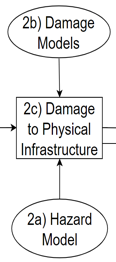

## 2a) Hazard Model (Hurricane)
There are currently five hurricane hazard data for Galveston testbed. Four of them were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. One of them is a surrogate model developed using USACE datasets.

| No. | Simulation type | Name | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Coupled ADCIRC+SWAN | Hurricane Ike Hindcast | <font color='red'>5fa5a228b6429615aeea4410 </font> | Darestani et al. (2021) |
| 2 | Coupled ADCIRC+SWAN | 2% AEP Hurricane Simulation | <font color='red'>5fa5a83c7e5cdf51ebf1adae </font> | Darestani et al. (2021) |
| 3 | Coupled ADCIRC+SWAN | 1% AEP Hurricane Simulation | <font color='red'>5fa5a9497e5cdf51ebf1add2 </font> | Darestani et al. (2021) |
| 4 | Coupled ADCIRC+SWAN | 0.2% AEP Hurricane Simulation | <font color='red'>5fa5aa19b6429615aeea4476 </font> | Darestani et al. (2021) |
| 5 | Kriging-based surrogate model | Galveston Deterministic Hurricane - Kriging | <font color='red'>5f15cd627db08c2ccc4e3bab </font> | Fereshtehnejad et al. (2021) |


### Coupled ADCIRC+SWAN
Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2% (50-yr return period), 1% (100-yr return period), and 0.2% (500-yr return period) Annual Exceedance Probabilities (AEP) hurricane simulations were created using ADCIRC+SWAN models. These hurricane hazard events contain **eight hazardDatasets**, which is five more than the current pyincore hurricane schema. Please be sure to adjust your codes accordingly if you need to incorporate the five new intensity measures (IMs). The existing schema includes the peak significant wave height, peak surge level, and inundation duration. These new events include those as well as maximum inundation depth, peak wave period, wave direction, maximum current speed, and maximum wind speed. 

### Kriging-based surrogate model
**Three hazardDatasets** of kriging-based surrogate models are developed for peak significant wave height, peak surge level, and inundation duration. Training datasets for developing the Kriging surorgate models were collected through USACE. For the peak significant wave height, peak surge level, and inundation duration the training datasets included 61, 251, and 254 synthetic storms, respectively. 

### Building damage

### 2.1 Building Fragility

The impact of the surge-wave action on buildings was assumed to be independent of the wind impacts. The surge-wave action was modeled using the surge-wave fragility surfaces developed by Do. et al. (2020), while the wind action was modeled using the wind fragility functions developed by Memari et al. (2018) assuming that the maximum hurricane wind speed does not occur with the maximum surge and wave height. None of the surge-wave and wind fragility used herein accounts for content damage. Therefore, the flood fragility functions developed by Nofal and van de Lindt (2020b) were used to account for content damage, i.e. due to surge. The vulnerability of structural components (e.g., roof, walls, foundation, slabs, etc.) was derived from the surge-wave fragility surface developed and the wind fragility curves developed after extracting the intensities of surge, wave, and wind speed from the hazard maps. The vulnerability of the interior contents and other non-structural components were calculated from flood fragility functions (e.g., depth fragility function, depth-duration fragility function) based on the extracted surge height.

### Building Damage:

The developed multi-hazard hurricane damage approach uses five input variables - significant wave height, the surge depth, building elevation from the ground, maximum wind speed, and flood duration, respectively. All these variables were used as inputs for three stages of fragility analysis to account for structure and content damage and losses for each building within the community. First, the significant wave height, the surge water depth, and elevation from the ground were used to account for the structural system exceedance probability of each DS using the multi-variate 3-D surge-wave fragility function developed by Do et al. (2020). Second, the maximum wind speed for each building was used to account for another list of exceedance probabilities for each DS using the fragility portfolio developed by Memari et al. (2018). Then, flood depth, and the building elevation from the ground for each building were used in a static flood fragility functions developed by Nofal and van de Lindt (2020) to account for content damage. For damage analysis, a single DS was assigned to each building based on the maximum DS calculated from surge-wave, wind, and flood Eq. (1). 


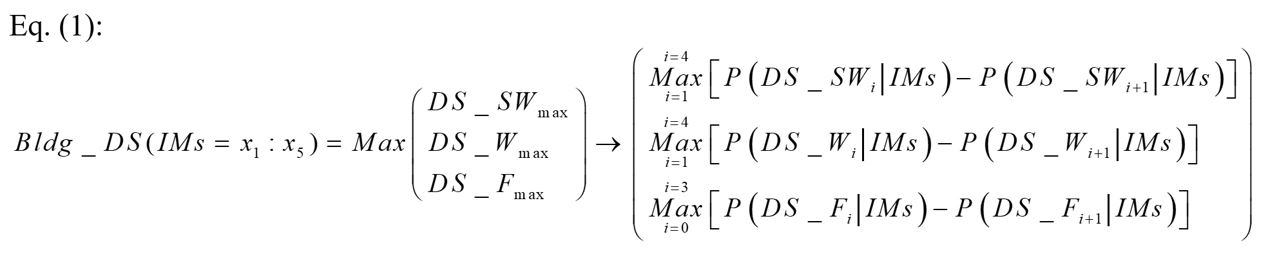

where Bldg_DS(IMs = x1: x5) is the building DS corresponding to the five intensity measures. P[DS_SWi|(IM = x1:x3)] = the exceedance probability of DS_SWi at (IMs = x1:x3) calculated from the surge-wave fragility, and  P[DS_SW i+1|(IM = x1:x3)] = the exceedance probability of DS_SWi+1 at (IMs = x1: x3) calculated from the surge-wave fragility. P[DS_Wi|(IM = x4)] = the exceedance probability of DS_Wi at (IMs = x4) calculated from the wind fragility, and  P[DS_W i+1|(IM = x4)] = the exceedance probability of DS_Wi+1 at (IMs = x1, x2,x3) calculated from the wind fragility. P[DS_Fi|(IM = x1, x3, x5)] = the exceedance probability of DS_Fi at (IMs = x1, x3, x5) calculated from the flood fragility, and  P[DS_F i+1|(IM = x1, x3, x5)] = the exceedance probability of DS_Fi+1 at (IMs = x1, x2,x3) calculated from the flood fragility.

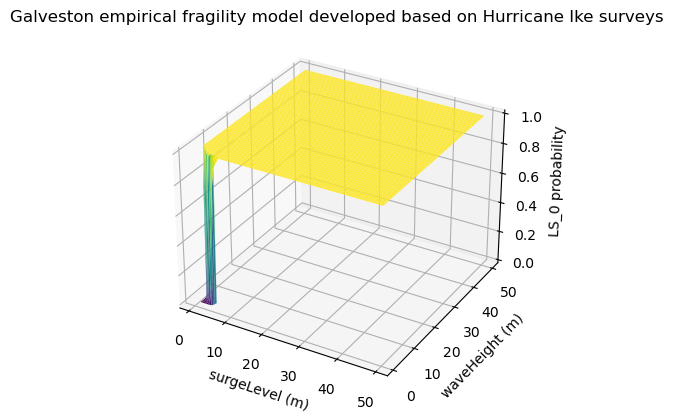

In [19]:
# use utility method of pyicore-viz package to visualize the fragility
fragility_set = FragilityCurveSet(FragilityService(client).get_dfr3_set("5f6ccf67de7b566bb71b202d"))
plt = plotviz.get_fragility_plot_3d(fragility_set, 
                                            title="Galveston empirical fragility model developed "
                                            "based on Hurricane Ike surveys",
                                            limit_state="LS_0")
plt.show()

In [20]:
hazard_type = "hurricane"
# Galveston deterministic Hurricane, 3 datasets - Kriging
hazard_id = "5fa5a228b6429615aeea4410"

# visualization
wave_height_id = "5f15cd62c98cf43417c10a3f"
surge_level_id = "5f15cd5ec98cf43417c10a3b"

# Hurricane building mapping (with equation)
mapping_id = "602c381a1d85547cdc9f0675"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

# Building Wind Fragility mapping
wind_mapping_id = "62fef3a6cef2881193f2261d"
wind_mapping_set = MappingSet(fragility_service.get_mapping(wind_mapping_id))

# Surge-wave mapping
sw_mapping_id = "6303e51bd76c6d0e1f6be080"
sw_mapping_set = MappingSet(fragility_service.get_mapping(sw_mapping_id))

# flood mapping
flood_mapping_id = "62fefd688a30d30dac57bbd7"
flood_mapping_set = MappingSet(fragility_service.get_mapping(flood_mapping_id))

In [21]:
# visualize wave height
dataset = Dataset.from_data_service(wave_height_id, DataService(client))
map = geoviz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [22]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

In [23]:
# visualize surge level
dataset = Dataset.from_data_service(surge_level_id, DataService(client))
map = geoviz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [24]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

### 2.2 Building Damage

### 2.2.1 Wind building damage

In [25]:
# wind building damage
w_bldg_dmg = BuildingDamage(client)
w_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
w_bldg_dmg.set_input_dataset('dfr3_mapping_set', wind_mapping_set)
w_bldg_dmg.set_parameter("result_name", "Galveston-wind-dmg")
w_bldg_dmg.set_parameter("hazard_type", hazard_type)
w_bldg_dmg.set_parameter("hazard_id", hazard_id)
w_bldg_dmg.set_parameter("num_cpu", 4)
w_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### 2.2.2 Surge-Wave building damage

In [26]:
# surge-wave building damage
bldg_dmg = BuildingDamage(client)
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
bldg_dmg.set_input_dataset('dfr3_mapping_set', sw_mapping_set)
bldg_dmg.set_parameter("result_name", "Galveston-sw-dmg")
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)
bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Flood building damage

In [27]:
# flood building damage
f_bldg_dmg = BuildingDamage(client)
f_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
f_bldg_dmg.set_input_dataset('dfr3_mapping_set', flood_mapping_set)
f_bldg_dmg.set_parameter("result_name", "Galveston-flood-dmg")
f_bldg_dmg.set_parameter("hazard_type", hazard_type)
f_bldg_dmg.set_parameter("hazard_id", hazard_id)
f_bldg_dmg.set_parameter("num_cpu", 4)
f_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Combine wind, wave and surge building damage

In [28]:
surge_wave_damage = bldg_dmg.get_output_dataset("ds_result")
wind_damage = w_bldg_dmg.get_output_dataset("ds_result")
flood_damage = f_bldg_dmg.get_output_dataset("ds_result")

result_name = "Galveston-combined-dmg"
combined_bldg_dmg = CombinedWindWaveSurgeBuildingDamage(client)
combined_bldg_dmg.set_input_dataset("surge_wave_damage", surge_wave_damage)
combined_bldg_dmg.set_input_dataset("wind_damage", wind_damage)
combined_bldg_dmg.set_input_dataset("flood_damage", flood_damage)
combined_bldg_dmg.set_parameter("result_name", result_name)
# combined_bldg_dmg.run_analysis()

# combined_dmg = combined_bldg_dmg.get_output_dataset("result")
# combined_dmg_df = combined_dmg.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
# combined_dmg_df.head()

True

### 2.3 Electric Power Facility Damage

In [22]:
# EPF fragility mapping
epf_mapping_id = "62fac92ecef2881193f22613"
epf_mapping_set = MappingSet(fragility_service.get_mapping(epf_mapping_id))

epf_dmg_hurricane_galveston = EpfDamage(client)
epf_dmg_hurricane_galveston.load_remote_input_dataset("epfs", "62fc000f88470b319561b58d")
epf_dmg_hurricane_galveston.set_input_dataset('dfr3_mapping_set', epf_mapping_set)
epf_dmg_hurricane_galveston.set_parameter("result_name", "Galveston-hurricane-epf-damage")
epf_dmg_hurricane_galveston.set_parameter("fragility_key", "Non-Retrofit Fragility ID Code")
epf_dmg_hurricane_galveston.set_parameter("hazard_type", hazard_type)
epf_dmg_hurricane_galveston.set_parameter("hazard_id", hazard_id)
epf_dmg_hurricane_galveston.set_parameter("num_cpu", 8)

# Run Analysis
epf_dmg_hurricane_galveston.run_analysis()

NameError: name 'fragility_service' is not defined

# 3) Functionality

## 3a) Functionality Models

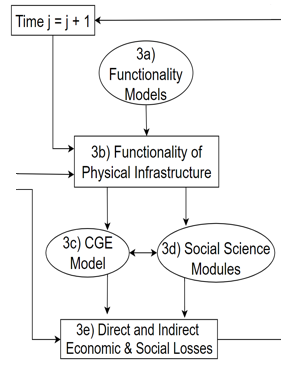

## 3b) Functionality of Physical Infrastructure

In [30]:
# Retrieve result dataset from surge_wave_damage
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

In [31]:
# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,1815653a-7b70-44ce-8544-e975596bdf82,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,df63f574-8e9b-426b-aa3b-b3757cb699b5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,a743ae24-4209-44e2-b11e-7a872f071ae9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


In [32]:
bdmg_df.DS_0.describe()

count    1.616450e+05
mean     9.034213e-01
std      2.621947e-01
min      3.279000e-07
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: DS_0, dtype: float64

In [33]:
bdmg_df.DS_3.describe()

count    161645.000000
mean          0.015951
std           0.110204
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.999997
Name: DS_3, dtype: float64

## 3d) Social Science Modules

Population Dislocation
Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

#### 3d.1 Use new pyincore-data utility to obtain Block Group Data for County

In [34]:
from pyincore_data.censusutil import CensusUtil
state_counties = ['48167']
blockgroup_df, bgmap = CensusUtil.get_blockgroupdata_for_dislocation(state_counties, 
                                                out_csv=True, 
                                                out_shapefile=False, 
                                                out_html=False,
                                                program_name = "BlockGroupData",
                                                geo_name = "Galveston")

INFO - censusutil.py:get_blockgroupdata_for_dislocation() - Census API data from: https://api.census.gov/data/2010/dec/sf1?get=GEO_ID,NAME,P005001,P005003,P005004,P005010&for=block%20group&in=state:48&in=county:167


1940
P005001 converted from object to integer
P005003 converted from object to integer
P005004 converted from object to integer
P005010 converted from object to integer
CSV data file saved to: BlockGroupData/BlockGroupData_Galveston.csv


In [35]:
blockgroup_df.head()


,bgid,bgidstr,Survey,pblackbg,phispbg
0,481677201001,BG481677201001,2010 dec/sf1,1.726539,8.911167
1,481677201002,BG481677201002,2010 dec/sf1,0.808407,18.108327
2,481677201003,BG481677201003,2010 dec/sf1,0.956023,17.304015
3,481677202001,BG481677202001,2010 dec/sf1,1.625282,6.952596
4,481677202002,BG481677202002,2010 dec/sf1,1.735488,9.634949


In [36]:
bg_data = Dataset.from_file(
    'BlockGroupData/BlockGroupData_Galveston.csv',
    'incore:blockGroupData')

#### 3d.2 Population Dislocation

In [37]:
pop_dis = PopulationDislocation(client)


In [38]:
# Value loss parameters DS 0-3
value_loss = "60354810e379f22e16560dbd"

In [39]:
pop_dis.set_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)
pop_dis.set_input_dataset("housing_unit_allocation", hua_result)

result_name = "galveston-pop-disl-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [40]:
pop_dis.run_analysis()

True

#### 3.d.3 Explore Population Dislocation Results

In [41]:
# Retrieve result dataset
population_dislocation_result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pd_df = population_dislocation_result.get_dataframe_from_csv(low_memory=False)

In [42]:
poptable.pop_results_table(pd_df, 
                  who = "Total Population by Households", 
                  what = "by Tenure Status and Dislocation",
                  where = "Galveston County TX",
                  when = "2010",
                  row_index = "Tenure Status",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 1 Dislocates
Tenure Status,,,,
1 Owner Occupied,"196,354 (71.8%)","7,079 (61.8%)","203,433 (71.4%)",3.5%
2 Renter Occupied,"77,154 (28.2%)","4,378 (38.2%)","81,532 (28.6%)",5.4%
Total,"273,508 (100.0%)","11,457 (100.0%)","284,965 (100.0%)",4.0%


In [43]:
poptable.pop_results_table(pd_df.loc[pd_df['placeNAME10']=='Galveston'].copy(),
                  who = "Total Population by Households", 
                  what = "by Tenure Status and Dislocation",
                  where = "Galveston County TX",
                  when = "2010",
                  row_index = "Tenure Status",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 1 Dislocates
Tenure Status,,,,
1 Owner Occupied,"18,236 (49.0%)","3,971 (52.1%)","22,207 (49.5%)",17.9%
2 Renter Occupied,"19,010 (51.0%)","3,653 (47.9%)","22,663 (50.5%)",16.1%
Total,"37,246 (100.0%)","7,624 (100.0%)","44,870 (100.0%)",17.0%


In [44]:
poptable.pop_results_table(pd_df.loc[pd_df['placeNAME10']=='Galveston'].copy(), 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity and Dislocation",
                  where = "Galveston County TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 1 Dislocates
Race Ethnicity,,,,
"1 White alone, Not Hispanic","16,630 (41.9%)","3,904 (51.2%)","20,534 (43.4%)",19.0%
"2 Black alone, Not Hispanic","6,848 (17.2%)","1,247 (16.4%)","8,095 (17.1%)",15.4%
"3 American Indian and Alaska Native alone, Not Hispanic",152 (0.4%),39 (0.5%),191 (0.4%),20.4%
"4 Asian alone, Not Hispanic","1,168 (2.9%)",221 (2.9%),"1,389 (2.9%)",15.9%
"5 Other Race, Not Hispanic",453 (1.1%),67 (0.9%),520 (1.1%),12.9%
"6 Any Race, Hispanic","11,995 (30.2%)","2,146 (28.1%)","14,141 (29.9%)",15.2%
7 Group Quarters no Race Ethnicity Data,"2,464 (6.2%)",nan (nan%),"2,464 (5.2%)",nan%
Total,"39,710 (100.0%)","7,624 (100.0%)","47,334 (100.0%)",16.1%


In [45]:
# Add household income group categories for table
# Code will be added to next release of pop_results_table on pyincore-viz
def add_label_cat_conditions_df(df, conditions):
    """Label Categorical Variable Values and add to dataframe.
    Use this function with values are based on conditions.
    
    Args:
        df (obj): Pandas DataFrame object.
        conditions (dict): Dictionary of conditions for value labels.
    Returns:
        object: Pandas DataFrame object.
    """

    cat_var = conditions['cat_var']['variable_label']

    df[cat_var] = "No Data"

    for item in conditions['condition_list'].keys():
        condition =  conditions['condition_list'][item]['condition']
        value_label = conditions['condition_list'][item]['value_label']
        df.loc[eval(condition), cat_var] = value_label

    # Set variable to missing if no data- makes tables look nicer
    df.loc[(df[cat_var] == "No Data"), 
        cat_var] = np.nan

    return df

def add_label_cat_values_df(df, valuelabels, variable = ''):
    """Label Categorical Variable Values and add to dataframe.
    Use this function with categorical values 
    are integer values.
    Args:
        df (obj): Pandas DataFrame object.
        valuelabels (dict): Dictionary of value labels.
        variable (str): Variable to label.
    Returns:
        object: Pandas DataFrame object with new column that has value labels.
    """

    if variable == '':
        variable  = valuelabels['categorical_variable']['variable']
    variable_label = valuelabels['categorical_variable']['variable_label']

    df[variable_label] = "No Data"

    for item in valuelabels['value_list'].keys():
        value =  valuelabels['value_list'][item]['value']
        value_label = valuelabels['value_list'][item]['value_label']
        df.loc[df[variable] == value, variable_label] = value_label

    # Set variable to missing if no data- makes tables look nicer
    df.loc[(df[variable_label] == "No Data"), 
        variable_label] = np.nan

    return df

hhinc_valuelabels = {'categorical_variable': {'variable' : 'hhinc',
                                'variable_label' : 'Household Income Group',
                                'notes' : '5 Household Income Groups based on random income.'},
                    'value_list' : {
                        1 : {'value': 1, 'value_label': "1 Less than $15,000"},
                        2 : {'value': 2, 'value_label': "2 $15,000 to $24,999"},
                        3 : {'value': 3, 'value_label': "3 $25,000 to $74,999"},
                        4 : {'value': 4, 'value_label': "4 $75,000 to $99,999"},
                        5 : {'value': 5, 'value_label': "5 $100,000 or more"}}
                    }

pd_df = add_label_cat_values_df(pd_df, valuelabels = hhinc_valuelabels)

In [46]:
poptable.pop_results_table(pd_df.loc[pd_df['placeNAME10']=='Galveston'].copy(),
                  who = "Total Households", 
                  what = "by Household Income Group and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Household Income Group",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Households (%),Percent Row 1 Dislocates
Household Income Group,,,,
"1 Less than $15,000","3,546 (21.6%)",682 (19.7%),"4,228 (21.3%)",16.1%
"2 $15,000 to $24,999","2,099 (12.8%)",411 (11.9%),"2,510 (12.6%)",16.4%
"3 $25,000 to $74,999","6,836 (41.7%)","1,474 (42.6%)","8,310 (41.8%)",17.7%
"4 $75,000 to $99,999","1,589 (9.7%)",344 (9.9%),"1,933 (9.7%)",17.8%
"5 $100,000 or more","2,329 (14.2%)",552 (15.9%),"2,881 (14.5%)",19.2%
Total,"16,399 (100.0%)","3,463 (100.0%)","19,862 (100.0%)",17.4%


#### 3.d.4 Explore Population Dislocation and Building Damage Results

In [47]:
ds3_conditions = {'cat_var' : {'variable_label' : 'Probability Complete Failure',
                         'notes' : 'Probability of complete failure based on damage state 3'},
              'condition_list' : {
                1 : {'condition': "(df['DS_3'] == 0)", 'value_label': "0 0%"},
                2 : {'condition': "(df['DS_3'] > 0)", 'value_label': "1 Less than 20%"},
                3 : {'condition': "(df['DS_3'] > .2)", 'value_label': "2 20-40%"},
                4 : {'condition': "(df['DS_3'] > .4)", 'value_label': "3 40-60%"},
                5 : {'condition': "(df['DS_3'] > .6)", 'value_label': "4 60-80%"},
                6 : {'condition': "(df['DS_3'] > .8)", 'value_label': "5 80-100%"},
                7 : {'condition': "(df['DS_3'] == 1)", 'value_label': "6 100%"}}
            }

      
dsf_valuelabels = {'categorical_variable' : {'variable' : 'd_sf',
                   'variable_label' : 'Single Family Dwelling',
                   'notes' : 'Categories for single family dwellings'},
              'value_list' : {
                1 : {'value': 0, 'value_label': "0 Not Single Family"},
                2 : {'value': 1, 'value_label': "1 Single Family"}}
            }

In [48]:

pd_df = add_label_cat_conditions_df(pd_df, conditions = ds3_conditions)
pd_df = add_label_cat_values_df(pd_df, valuelabels = dsf_valuelabels)

In [49]:
poptable.pop_results_table(pd_df.loc[pd_df['placeNAME10']=='Galveston'].copy(), 
                  who = "Total Households", 
                  what = "by Probability of Complete Failure and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Probability Complete Failure',
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Households (%),Percent Row 1 Dislocates
Probability Complete Failure,,,,
0 0%,"7,541 (30.1%)",171 (2.6%),"7,712 (24.4%)",2.2%
1 Less than 20%,"17,288 (69.0%)","5,816 (88.8%)","23,104 (73.1%)",25.2%
2 20-40%,64 (0.3%),88 (1.3%),152 (0.5%),57.9%
3 40-60%,88 (0.4%),168 (2.6%),256 (0.8%),65.6%
4 60-80%,31 (0.1%),97 (1.5%),128 (0.4%),75.8%
5 80-100%,52 (0.2%),210 (3.2%),262 (0.8%),80.2%
Total,"25,064 (100.0%)","6,550 (100.0%)","31,614 (100.0%)",20.7%


In [50]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8) &
                                     (pd_df['placeNAME10']=='Galveston')].copy(),
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Single Family Dwelling",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Single Family Dwelling',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 0 Does not dislocate
Single Family Dwelling,,,,
0 Not Single Family,21 (91.3%),51 (85.0%),72 (86.7%),29.2%
1 Single Family,2 (8.7%),9 (15.0%),11 (13.3%),18.2%
Total,23 (100.0%),60 (100.0%),83 (100.0%),27.7%


In [51]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8) &
                                     (pd_df['placeNAME10']=='Galveston')].copy(),
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 0 Does not dislocate
Race Ethnicity,,,,
"1 White alone, Not Hispanic",15 (65.2%),56 (93.3%),71 (85.5%),21.1%
"3 American Indian and Alaska Native alone, Not Hispanic",nan (nan%),3 (5.0%),3 (3.6%),nan%
"4 Asian alone, Not Hispanic",3 (13.0%),nan (nan%),3 (3.6%),100.0%
"6 Any Race, Hispanic",nan (nan%),1 (1.7%),1 (1.2%),nan%
7 Group Quarters no Race Ethnicity Data,5 (21.7%),nan (nan%),5 (6.0%),100.0%
Total,23 (100.0%),60 (100.0%),83 (100.0%),27.7%


# 4) Recovery

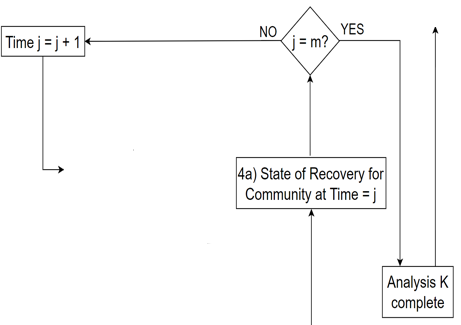

* **j** is the index for time 
* **m** is the community lifetime
* **K** is the index for policy levers and decision combinations (PD)

### 4.1 Household-Level Housing Recovery Analysis

The Household-Level Housing Recovery (HHHR) model developed by Sutley and Hamideh (2020) is used to simulate the housing recovery process of dislocated households.

The computation operates by segregating household units into five zones as a way of assigning social vulnerability. Then, using this vulnerability in conjunction with the Transition Probability Matrix (TPM) and the initial state vector, a Markov chain computation simulates the most probable states to generate a stage history of housing recovery changes for each household. The detailed process of the HHHR model can be found in Sutley and Hamideh (2020).

>Sutley, E.J. and Hamideh, S., 2020. Postdisaster housing stages: a Markov chain approach to model sequences and duration based on social vulnerability. Risk Analysis, 40(12), pp.2675-2695.

The Markov chain model consists of five discrete states at any time throughout the housing recovery process. The five discrete states represent stages in the household housing recovery process, including emergency shelter (1), temporary shelter (2); temporary housing (3); permanent housing (4), and failure to recover (5). The model assumes that a household can be in any of the first four stages immediately after a disaster. If the household reported not being dislocated, household will begin in stage 4. 

### 4.2 Set Up and Run Household-level Housing Sequential Recovery

In [52]:
# Parameters
state = "texas"
county = "galveston"
year = 2020

In [53]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]

In [54]:
def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

    _, df_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                              data_source="acs/acs5",
                                                              columns="GEO_ID,B03002_001E,B03002_003E",
                                                              geo_type=geo_type)
    df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"], axis = 1)

    _, df_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                  data_source="acs/acs5",
                                                  columns="B25003_001E,B25003_002E",
                                                  geo_type=geo_type)
    df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"], axis = 1)
    
    _, df_3 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B17021_001E,B17021_002E",
                                         geo_type=geo_type)
    df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"], axis = 1)
    
    _, df_4 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5", 
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=geo_type)
    df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
                                                                                                    + row["B15003_018E"] 
                                                                                                    + row["B15003_019E"] 
                                                                                                    + row["B15003_020E"] 
                                                                                                    + row["B15003_021E"] 
                                                                                                    + row["B15003_022E"] 
                                                                                                    + row["B15003_023E"] 
                                                                                                    + row["B15003_024E"] 
                                                                                                    + row["B15003_025E"])/row["B15003_001E"], axis = 1)

    if geo_type == 'tract:*':
        _, df_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                             geo_type=geo_type)
        df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"], axis = 1)
    
    elif geo_type == 'block%20group:*':
        _, df_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
                                             geo_type=geo_type)

        df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
                                                                                 row['C21007_006E']+
                                                                                 row['C21007_009E']+
                                                                                 row['C21007_013E'])
                                                                                /row['C21007_016E'], axis = 1)

    df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
                      df_2["factor_owner_occupied"],
                      df_3["factor_earning_higher_than_national_poverty_rate"], 
                      df_4["factor_over_25_with_high_school_diploma_or_higher"],
                      df_5["factor_without_disability_age_18_to_65"]], 
                     axis=1, join='inner')
    
    # extract FIPS from geo id
    df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
    return df_t

In [55]:
def national_ave_values(year, data_source="acs/acs5"):
    _, nav1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B03002_001E,B03002_003E",geo_type=None)
    nav1 = nav1.astype(int)
    nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
                "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

    _, nav2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B25003_001E,B25003_002E",geo_type=None)
    nav2 = nav2.astype(int)
    nav2_avg = {"feature": "NAV-2: Home Owners", 
                "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

    _, nav3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B17021_001E,B17021_002E",geo_type=None)
    nav3 = nav3.astype(int)
    nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
                "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

    _, nav4 = CensusUtil.get_census_data(state="*", 
                                         county=None, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=None)
    nav4 = nav4.astype(int)
    nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
                              row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
                              row['B15003_024E']+row['B15003_025E'], axis = 1)
    nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
                "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

    _, nav5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                         geo_type=None)
    nav5 = nav5.astype(int)
    nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
    nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
                "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
    navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
    return navs

In [56]:
navs = national_ave_values(year=year)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

geo_type = "block%20group:*"
# geo_type = "tract:*"
social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=year, geo_type=geo_type)

# Temp fix: remove bad data point
social_vunlnerability_dem_factors_df = social_vunlnerability_dem_factors_df.dropna()

social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

In [57]:
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vunlnerability_dem_factors)

True

In [58]:
# Run social vulnerability damage analysis
result = social_vulnerability.run_analysis()

In [59]:
# Retrieve result dataset
sv_result = social_vulnerability.get_output_dataset("sv_result")

# Convert dataset to Pandas DataFrame
df = sv_result.get_dataframe_from_csv()

# Display top 5 rows of output data
df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1500000US481677201001,0.826873,0.857143,0.836348,0.985014,0.075404,481677201001,1.389439,1.330196,0.962965,1.114087,0.137041,0.986746,Medium Vulnerable (zone3)
1,1500000US481677201002,0.676741,0.889262,0.894875,0.929273,0.176230,481677201002,1.137164,1.380041,1.030353,1.051042,0.320285,0.983777,Medium Vulnerable (zone3)
2,1500000US481677201003,0.517323,0.809955,0.984252,0.980989,0.056364,481677201003,0.869285,1.256965,1.133261,1.109534,0.102437,0.894296,Medium to High Vulnerable (zone4)
3,1500000US481677201004,0.561679,1.000000,1.000000,0.919908,0.061051,481677201004,0.943819,1.551895,1.151393,1.040451,0.110956,0.959703,Medium Vulnerable (zone3)
4,1500000US481677202001,0.701548,0.973113,0.987214,0.973601,0.062718,481677202001,1.178848,1.510169,1.136671,1.101179,0.113985,1.008170,Medium Vulnerable (zone3)


In [26]:
# Transition probability matrix per social vulnerability level, from Sutley and Hamideh (2020).
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for household at time 0
initial_probability_vector = "60f5e918544e944c3cec668b"

In [61]:
# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets from dislocation, tpm, and initial probability function
#housing_recovery.load_remote_input_dataset("population_dislocation_block", population_dislocation)
housing_recovery.set_input_dataset("population_dislocation_block", population_dislocation_result)

housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [62]:
# Initial value to seed the random number generator to ensure replication
seed = 1234
# A size of the analysis time step in month
t_delta = 1.0
# Total duration of Markov chain recovery process
t_final = 90.0

In [63]:
# Specify the result name
result_name = "housing_recovery_result"

# Set analysis parameters
housing_recovery.set_parameter("result_name", result_name)
housing_recovery.set_parameter("seed", seed)
housing_recovery.set_parameter("t_delta", t_delta)
housing_recovery.set_parameter("t_final", t_final)

# Chain with SV output
housing_recovery.set_input_dataset('sv_result', sv_result)

# Run the household recovery sequence analysis - Markov model
housing_recovery.run()

## 6 a) Sufficient Quality Solutions Found?

In [64]:
# Retrieve result dataset
housing_recovery_result = housing_recovery.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
df_hhrs = housing_recovery_result.get_dataframe_from_csv()

# Display top 5 rows of output data
df_hhrs.head()

,guid,huid,Zone,SV,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90
0,df7e5aef-c49f-45dd-b145-6fd7db8f50ff,B481677201001000H222,Z3,0.524,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,07b29b24-3184-4d0b-bbc6-1538aee5b1f1,B481677201001000H076,Z3,0.557,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,6d9c5304-59ff-4fb4-a8cf-d746b98f95fb,B481677201001000H160,Z3,0.455,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,2f76cc1d-ee76-445c-b086-2cd331ed7b1b,B481677201001000H084,Z3,0.560,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,cdcedef2-2948-459f-b453-3fcc19076d91,B481677201001000H182,Z3,0.950,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


### Explore Household-level Housing Recovery Results

In [65]:
df_hhrs['1'].describe()

count    77398.000000
mean         3.702861
std          0.890408
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: 1, dtype: float64

In [66]:
# Locate observations where timestep 1 does not equal 4
df_hhrs[df_hhrs['13'] != 4].head()

,guid,huid,Zone,SV,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90
14327,840a174d-fe0b-4e7f-9490-de70e6972268,B481677210001005H011,Z4,0.655,1.0,2.0,3.0,2.0,3.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
14339,7e852dc1-e2f3-454c-96fb-024f80f3d36c,B481677210001005H012,Z4,0.827,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
14343,6d6d79b3-50b0-43f8-a5fa-15a0ab91e30d,B481677210001007H012,Z4,0.799,2.0,2.0,1.0,2.0,1.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
14363,e9d5a4ed-5356-4674-af60-7165c29a1e3f,B481677210001007H017,Z4,0.674,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
14369,61c09dbe-5099-4dc5-8b94-87750fe340a3,B481677210001007H053,Z4,0.760,1.0,1.0,2.0,3.0,3.0,2.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0



> Plot Housing Recovery Sequence Results

>view recovery sequence results for specific households

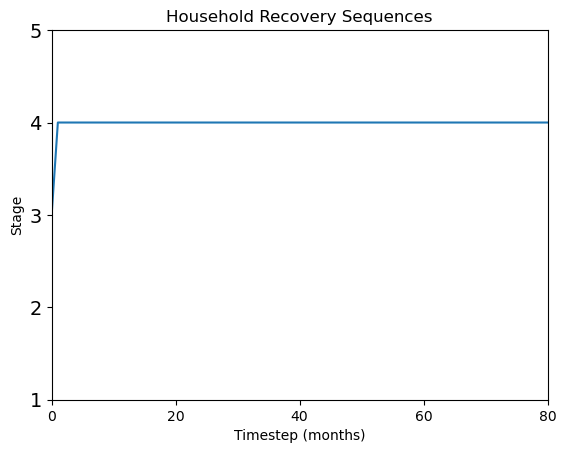

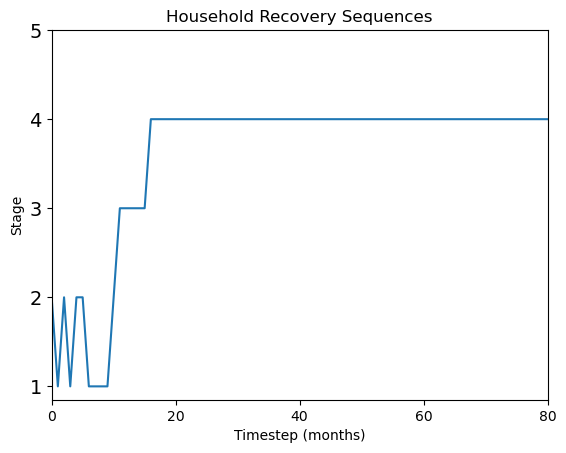

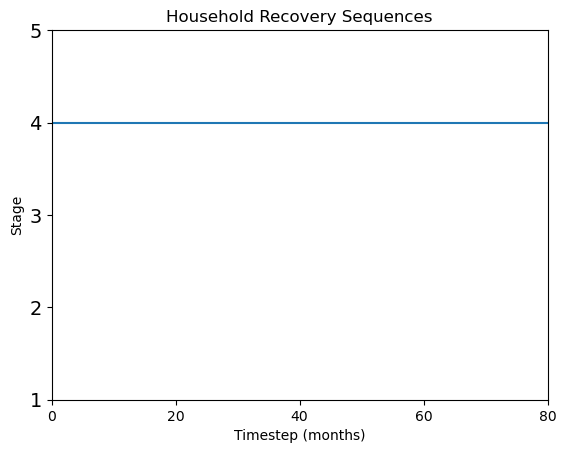

In [67]:
df=df_hhrs.drop(['guid', 'huid', 'Zone', 'SV'], axis=1).copy()
df=df.to_numpy()
t_steps=int(t_final)-1

# Plot stage histories and stage changes using pandas.
# Generate timestep labels for dataframes.
label_timestep = []
for i4 in range(0, t_steps):
    label_timestep.append(str(i4))
    
ids = [9700,14343,48] # select specific household by id numbers
for id in ids:
    HH_stagehistory_DF = pd.DataFrame(np.transpose(df[id, 1:]),
                                      index=label_timestep)
    ax = HH_stagehistory_DF.reset_index().plot(x='index',
                                               yticks=[1, 2, 3, 4, 5],
                                               title='Household Recovery Sequences',
                                               legend=False)
    ax.set(xlabel='Timestep (months)', ylabel='Stage')
    y_ticks_labels = ['1','2','3','4','5']
    ax.set_xlim(0,80)
    ax.set_yticklabels(y_ticks_labels, fontsize = 14)

> Plot recovery heatmap any stage of recovery

In [68]:
df_hhrs.head()

,guid,huid,Zone,SV,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90
0,df7e5aef-c49f-45dd-b145-6fd7db8f50ff,B481677201001000H222,Z3,0.524,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,07b29b24-3184-4d0b-bbc6-1538aee5b1f1,B481677201001000H076,Z3,0.557,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,6d9c5304-59ff-4fb4-a8cf-d746b98f95fb,B481677201001000H160,Z3,0.455,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,2f76cc1d-ee76-445c-b086-2cd331ed7b1b,B481677201001000H084,Z3,0.560,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,cdcedef2-2948-459f-b453-3fcc19076d91,B481677201001000H182,Z3,0.950,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [69]:
# Keep housing units for Galveston Island
pd_df_community = pd_df.loc[pd_df['placeNAME10']=='Galveston'].copy()
pd_df_community['placeNAME10'].describe()

count         32128
unique            1
top       Galveston
freq          32128
Name: placeNAME10, dtype: object

In [70]:
# merge household unit information with recovery results
pd_df_hs = pd.merge(left = pd_df_community, 
                    right = df_hhrs,
                    left_on=['guid','huid'],
                    right_on=['guid','huid'],
                    how='left')

In [71]:
pd_df_hs[['guid','huid']].describe()

,guid,huid
count,32128,32128
unique,19983,32128
top,2669f722-ae95-4181-90a8-9c4755b7b29c,B481677240001010H034
freq,191,1


### Create recovery curve based on income groups
Code will loop through data over time to create percent in permanent housing at each time step.

In [72]:
def recovery_curve_byincome(pd_df_hs, 
                            filename,
                            subtitle : str = ""):
    """
    Generate a recovery curve based on building damage, population dislocation,
    and household housing recovery model.
    
    """
    total_housingunits = pd_df_hs.shape[0]
    total_households = pd_df_hs.loc[(pd_df_hs['randincome'].notnull())].shape[0]
    #print("Total housing units:", total_housingunits)
    #print("Total households:", total_households)

    # What is the distribution of housing units by income?
    pd_df_hs['income_quantile'] = pd.qcut(pd_df_hs['randincome'], 5, labels=False)
    #pd_df_hs[['randincome','income_quantile']].groupby('income_quantile').describe()

    total_lowincomehouseholds = pd_df_hs.loc[(pd_df_hs['income_quantile'] == 0)].shape[0]
    total_midincomehouseholds = pd_df_hs.loc[(pd_df_hs['income_quantile'] == 2)].shape[0]
    total_highincomehouseholds = pd_df_hs.loc[(pd_df_hs['income_quantile'] == 4)].shape[0]
    #print("Total low income households:", total_lowincomehouseholds)
    #print("Total mid income households:", total_midincomehouseholds)
    #print("Total high income households:", total_highincomehouseholds)

    # loop over variables 1 to 90
    dict = {}
    # Create dataframe to store values
    # Assume at time 0, all households are in permanent housing
    dict[str(0)] = pd.DataFrame([{'timestep' : 0,
                    'total_households' : total_housingunits,
                    'notperm': 0,
                    'total_highincomehouseholds': total_highincomehouseholds,
                    'total_midincomehouseholds': total_midincomehouseholds,
                    'total_lowincomehouseholds': total_lowincomehouseholds,
                    'lowincome_notperm': 0,
                    'midincome_notperm': 0,
                    'highincome_notperm': 0}])

    for i in range(1,91):
        # create dictionary entry that summarizes the number of households not in permanent housing
        households_notinpermanthousing = pd_df_hs.loc[(pd_df_hs[str(i)] != 4) & 
                                                    (pd_df_hs[str(i)].notnull()) &
                                                    (pd_df_hs['randincome'].notnull())].shape[0]
        lowincome_households_notinpermanthousing = pd_df_hs.loc[(pd_df_hs[str(i)] != 4) &
                                                    (pd_df_hs[str(i)].notnull()) &
                                                    (pd_df_hs['income_quantile'] == 0)].shape[0]
        midincome_households_notinpermanthousing = pd_df_hs.loc[(pd_df_hs[str(i)] != 4) &
                                                    (pd_df_hs[str(i)].notnull()) &
                                                    (pd_df_hs['income_quantile'] == 2)].shape[0]
        highincome_households_notinpermanthousing = pd_df_hs.loc[(pd_df_hs[str(i)] != 4) &
                                                    (pd_df_hs[str(i)].notnull()) &
                                                    (pd_df_hs['income_quantile'] == 4)].shape[0]
                                        
        # Create dataframe to store values
        dict[str(i)] = pd.DataFrame([{'timestep' : i,
                        'total_households' : total_households,
                        'notperm': households_notinpermanthousing,
                        'total_highincomehouseholds': total_highincomehouseholds,
                        'total_midincomehouseholds': total_midincomehouseholds,
                        'total_lowincomehouseholds': total_lowincomehouseholds,
                        'lowincome_notperm': lowincome_households_notinpermanthousing,
                        'midincome_notperm': midincome_households_notinpermanthousing,
                        'highincome_notperm': highincome_households_notinpermanthousing}])

    # convert dictionary to dataframe
    df_summary = pd.concat(dict.values())
    df_summary['percent_allperm'] = 1 - (df_summary['notperm']/ \
                                        df_summary['total_households'] )
    df_summary['percent_lowperm'] = 1 - (df_summary['lowincome_notperm']/ \
                                    df_summary['total_lowincomehouseholds'] )
    df_summary['percent_midperm'] = 1 - (df_summary['midincome_notperm']/ \
                                        df_summary['total_midincomehouseholds'] )
    df_summary['percent_highperm'] = 1 - (df_summary['highincome_notperm']/ \
                                    df_summary['total_highincomehouseholds'] )

    # plot
    # Start new figure
    fig = plt.figure(figsize=(10,6))
    plt.plot('timestep', 'percent_allperm',
            data = df_summary,
            linestyle='-', marker='o', color='black')
    plt.plot('timestep', 'percent_lowperm',
            data = df_summary,
            linestyle='-', marker='o')
    plt.plot('timestep', 'percent_midperm',
            data = df_summary,
            linestyle='-', marker='o')   
    plt.plot('timestep', 'percent_highperm',
            data = df_summary,
            linestyle='-', marker='o')
    # Set y-axis range
    # What is the minimum and maximum values of the percent of households in permanent housing?
    ylim_lower = df_summary['percent_allperm'].min()-.1
    ylim_upper = df_summary['percent_allperm'].max()+.1
    plt.ylim(ylim_lower,ylim_upper)
    # Relable legend
    plt.legend(['All Households','Low Income Households', 'Mid Income', 'High Income'],
                loc='lower right')
    # Add title
    plt.title('Percentage of households in permanent housing by income'+subtitle)
    # Add x and y labels
    plt.xlabel('Timestep (months)')
    plt.ylabel('Percentage')
    # save plot
    plt.savefig(f'{filename}.pdf', bbox_inches='tight', dpi = 1000)

    plt.show()
    # good practice to close the plt object.
    plt.close()


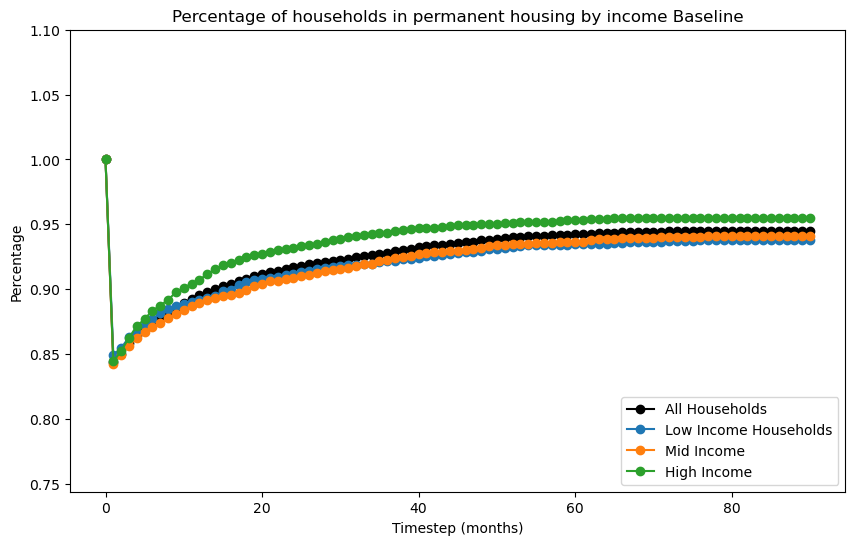

In [73]:
# Create container to store filenames (use to make a GIF)
# https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
filenames = []
i = 0
recovery_curve_byincome(pd_df_hs = pd_df_hs, 
                        filename = f'recovery_curve_byincome{i}',
                        subtitle=' Baseline')
filenames.append(filename)

> Plot recovery heatmap after 12 months of recovery

In [74]:
from ipyleaflet import Map, Heatmap, LayersControl, LegendControl

# What location should the map be centered on?
center_x = pd_df_hs['x'].mean()
center_y = pd_df_hs['y'].mean()

map = Map(center=[center_y, center_x], zoom=11)

stage5_data = pd_df_hs[['y','x','numprec']].loc[pd_df_hs['85']==5].values.tolist()
stage5 = Heatmap(
    locations = stage5_data,
    radius = 5, 
    max_val = 1000, 
    blur = 10, 
    gradient={0.2: 'yellow', 0.5: 'orange', 1.0: 'red'},
    name = 'Stage 5 - Failure to Recover',
)

stage4_data = pd_df_hs[['y','x','numprec']].loc[pd_df_hs['85']==4].values.tolist()
stage4 = Heatmap(
    locations = stage4_data,
    radius = 5, 
    max_val = 1000, 
    blur = 10, 
    gradient={0.2: 'purple', 0.5: 'blue', 1.0: 'green'},
    name = 'Stage 4 - Permanent Housing',
)

map.add_layer(stage4)
map.add_layer(stage5)


control = LayersControl(position='topright')
map.add_control(control)
map


Map(center=[29.268715167723066, -94.84083671833146], controls=(ZoomControl(options=['position', 'zoom_in_text'…

The five discrete states represent stages in the household housing recovery process, including emergency shelter (1), temporary shelter (2); temporary housing (3); permanent housing (4), and failure to recover (5). The model assumes that a household can be in any of the first four stages immediately after a disaster.

In [75]:
hhrs_valuelabels = {'categorical_variable' : {'variable' : 'select time step',
                   'variable_label' : 'Household housing recovery stages',
                   'notes' : 'Sutley and Hamideh recovery stages'},
              'value_list' : {
                1 : {'value': 1, 'value_label': "1 Emergency Shelter"},
                2 : {'value': 2, 'value_label': "2 Temporary Shelter"},
                3 : {'value': 3, 'value_label': "3 Temporary Housing"},
                4 : {'value': 4, 'value_label': "4 Permanent Housing"},
                5 : {'value': 5, 'value_label': "5 Failure to Recover"}}
            }

permanenthousing_valuelabels = {'categorical_variable' : {'variable' : 'select time step',
                   'variable_label' : 'Permanent Housing',
                   'notes' : 'Sutley and Hamideh recovery stages'},
              'value_list' : {
                1 : {'value': 1, 'value_label': "0 Not Permanent Housing"},
                2 : {'value': 2, 'value_label': "0 Not Permanent Housing"},
                3 : {'value': 3, 'value_label': "0 Not Permanent Housing"},
                4 : {'value': 4, 'value_label': "1 Permanent Housing"},
                5 : {'value': 5, 'value_label': "0 Not Permanent Housing"}}
            }

pd_df_hs = add_label_cat_values_df(pd_df_hs, valuelabels = hhrs_valuelabels, variable = '13')
pd_df_hs = add_label_cat_values_df(pd_df_hs, valuelabels = permanenthousing_valuelabels,
                        variable = '13')

In [76]:
poptable.pop_results_table(pd_df_hs.loc[(pd_df_hs['placeNAME10']=='Galveston')].copy(), 
                  who = "Total Population by Householder", 
                  what = "by Housing Type at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Household housing recovery stages',
                  row_percent = '2 Temporary Shelter'
                  )

Household housing recovery stages,1 Emergency Shelter (%),2 Temporary Shelter (%),3 Temporary Housing (%),4 Permanent Housing (%),5 Failure to Recover (%),Total Population by Householder (%),Percent Row 2 Temporary Shelter
Race Ethnicity,,,,,,,
"1 White alone, Not Hispanic",358 (50.2%),443 (50.7%),244 (55.5%),"8,572 (52.3%)",1 (25.0%),"9,618 (52.2%)",4.6%
"2 Black alone, Not Hispanic",139 (19.5%),159 (18.2%),77 (17.5%),"2,799 (17.1%)",1 (25.0%),"3,175 (17.2%)",5.0%
"3 American Indian and Alaska Native alone, Not Hispanic",6 (0.8%),3 (0.3%),2 (0.5%),68 (0.4%),nan (nan%),79 (0.4%),3.8%
"4 Asian alone, Not Hispanic",15 (2.1%),33 (3.8%),15 (3.4%),566 (3.5%),nan (nan%),629 (3.4%),5.2%
"5 Other Race, Not Hispanic",7 (1.0%),6 (0.7%),1 (0.2%),202 (1.2%),nan (nan%),216 (1.2%),2.8%
"6 Any Race, Hispanic",188 (26.4%),230 (26.3%),101 (23.0%),"4,153 (25.3%)",2 (50.0%),"4,674 (25.4%)",4.9%
7 Group Quarters no Race Ethnicity Data,nan (nan%),nan (nan%),nan (nan%),26 (0.2%),nan (nan%),26 (0.1%),nan%
Total,713 (100.0%),874 (100.0%),440 (100.0%),"16,386 (100.0%)",4 (100.0%),"18,417 (100.0%)",4.7%


In [77]:
poptable.pop_results_table(pd_df_hs.loc[pd_df_hs['placeNAME10']=='Galveston'].copy(),
                  who = "Total Population by Householder", 
                  what = "by Permanent Housing at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Permanent Housing',
                  row_percent = "0 Not Permanent Housing"
                  )

Permanent Housing,0 Not Permanent Housing (%),1 Permanent Housing (%),Total Population by Householder (%),Percent Row 0 Not Permanent Housing
Race Ethnicity,,,,
"1 White alone, Not Hispanic","1,046 (51.5%)","8,572 (52.3%)","9,618 (52.2%)",10.9%
"2 Black alone, Not Hispanic",376 (18.5%),"2,799 (17.1%)","3,175 (17.2%)",11.8%
"3 American Indian and Alaska Native alone, Not Hispanic",11 (0.5%),68 (0.4%),79 (0.4%),13.9%
"4 Asian alone, Not Hispanic",63 (3.1%),566 (3.5%),629 (3.4%),10.0%
"5 Other Race, Not Hispanic",14 (0.7%),202 (1.2%),216 (1.2%),6.5%
"6 Any Race, Hispanic",521 (25.7%),"4,153 (25.3%)","4,674 (25.4%)",11.1%
7 Group Quarters no Race Ethnicity Data,nan (nan%),26 (0.2%),26 (0.1%),nan%
Total,"2,031 (100.0%)","16,386 (100.0%)","18,417 (100.0%)",11.0%


## 8b) Policy Lever and Decision Combinations
Hypothetical scenario to elevate all buildings in inventory.

Running Analysis: 0


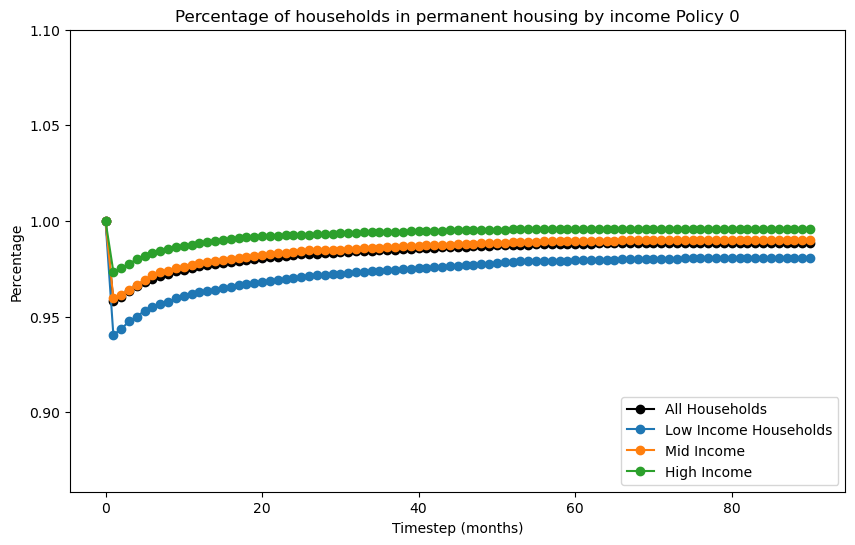

Running Analysis: 1


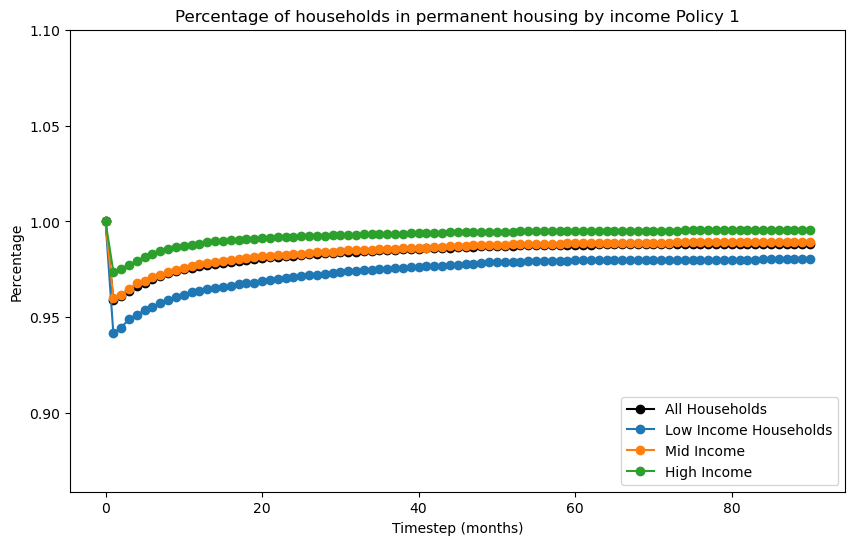

Running Analysis: 2


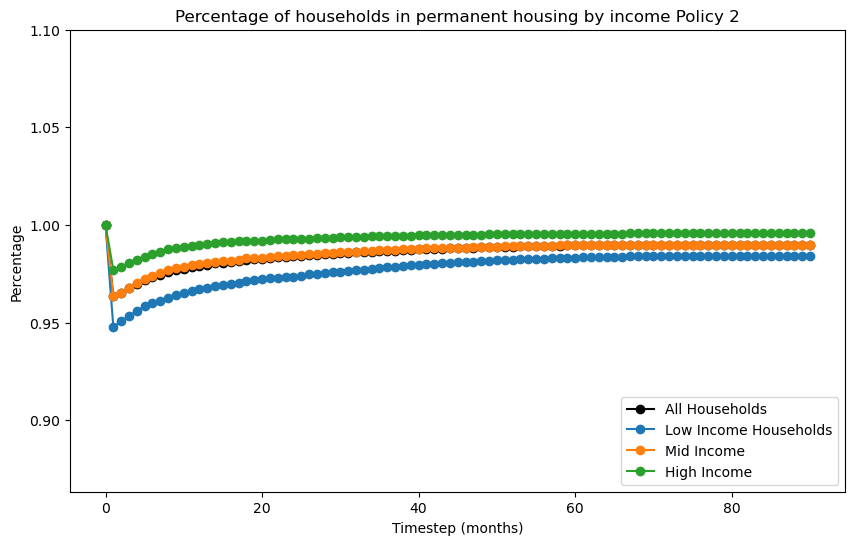

Running Analysis: 3


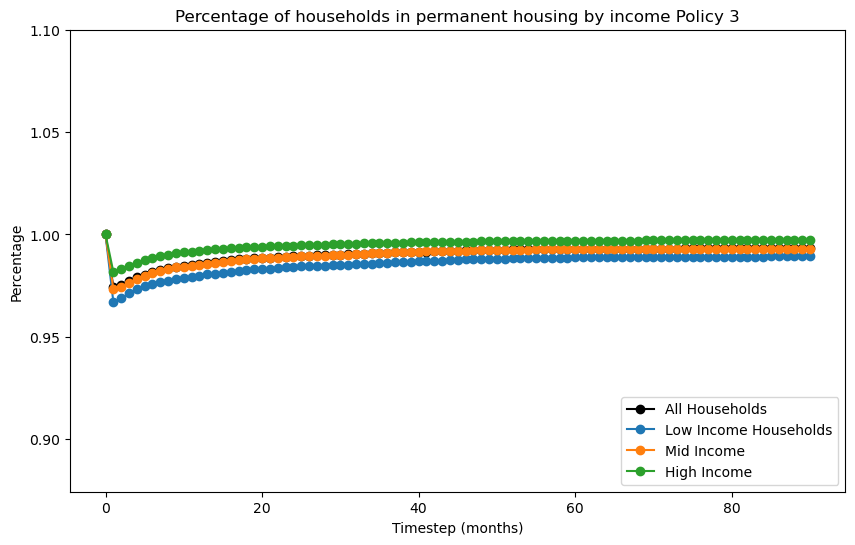

In [94]:
# Create container to store filenames (use to make a GIF)
# https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
recovery_curve_filenames = []
bldg_gdf_policy2 = bldg_df.copy()
#for i in range(18): 
for i in range(4): 
    
    ################## 1a) updated building inventory ##################  
    print(f"Running Analysis: {i}")
    if i>0:
        bldg_gdf_policy2.loc[bldg_gdf_policy2['ffe_elev'].le(16), 'ffe_elev'] += 4
        #bldg_gdf_policy2.loc[bldg_gdf_policy2['lhsm_elev'].le(16), 'lhsm_elev'] += 1

        bldg_gdf_policy2.to_csv(f'input_df_{i}.csv')
    # Save new shapefile and then use as new input to building damage model
    bldg_gdf_policy2.to_file(driver = 'ESRI Shapefile', filename = f'bldg_gdf_policy_{i}.shp')
    # Plot and save
    #geoviz.plot_gdf_map(bldg_gdf_policy2, column='lhsm_elev',category='False')
    # Code to save the results here
    ####################################################################      
    #
    #
    ################## 2c) Damage to Physical Infrastructure ##################  
    building_inv_policy2 = Dataset.from_file(file_path = f'bldg_gdf_policy_{i}.shp',
                                        data_type='ergo:buildingInventoryVer7')
    # surge-wave building damage
    bldg_dmg = BuildingDamage(client)
    #bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    bldg_dmg.set_input_dataset("buildings", building_inv_policy2)
    bldg_dmg.set_input_dataset("dfr3_mapping_set", sw_mapping_set)

    result_name = "Galveston-sw-dmg"

    bldg_dmg.set_parameter("result_name", result_name)
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)

    bldg_dmg.run_analysis()
    ###########################################################################
    #
    #
    ################## 3b) Functionality of Physical Infrastructure ##################
    # Retrieve result dataset
    building_dmg_result_policy2 = bldg_dmg.get_output_dataset('ds_result')
    # Convert dataset to Pandas DataFrame
    bdmg_policy2_df = building_dmg_result_policy2.get_dataframe_from_csv(low_memory=False)
    bdmg_policy2_df.DS_0.describe()
    bdmg_policy2_df.DS_3.describe()
    # Save CSV files for post processing
    bdmg_policy2_df.to_csv(f"bld_damage_results_policy_{i}.csv")
    ##################################################################################
    #
    #
    ############################  3d) Social Science Modules ############################   
    # update building damage
    pop_dis.set_input_dataset("building_dmg", building_dmg_result_policy2)

    # Update file name for saving results
    result_name = "galveston-pop-disl-results_policy2"
    pop_dis.set_parameter("result_name", result_name)
    
    pop_dis.run_analysis()
    
    # Retrieve result dataset
    population_dislocation_result_policy2 = pop_dis.get_output_dataset("result")

    # Convert dataset to Pandas DataFrame
    pd_df_policy2 = population_dislocation_result_policy2.get_dataframe_from_csv(low_memory=False)
    # Save CSV files for post processing
    pd_df_policy2.to_csv(f"pd_df_results_policy_{i}.csv")
    ######################################################################################
    #
    #
    ############################  4) Recovery ############################   
    # Update population dislocation
    housing_recovery.set_input_dataset("population_dislocation_block", 
                            population_dislocation_result_policy2)
    # Update file name for saving results
    result_name = "housing_recovery_result_policy2"
    # Set analysis parameters
    housing_recovery.set_parameter("result_name", result_name)
    housing_recovery.set_parameter("seed", seed)
    
    # Run the household recovery sequence analysis - Markov model
    housing_recovery.run()
    
    # Retrieve result dataset
    housing_recovery_result_policy2 = housing_recovery.get_output_dataset("ds_result")

    # Convert dataset to Pandas DataFrame
    df_hhrs_policy2 = housing_recovery_result_policy2.get_dataframe_from_csv()
    # Save CSV files for post processing
    df_hhrs_policy2.to_csv(f"df_hhrs_results_policy_{i}.csv")

    # merge household unit information with recovery results
    pd_hhrs_df = pd.merge(left = pd_df_policy2, 
                        right = df_hhrs_policy2,
                        left_on=['guid','huid'],
                        right_on=['guid','huid'],
                        how='left')

    # Plot recovery curve
    filename = f"recovery_curve_policy_{i}"
    recovery_curve_byincome(pd_df_hs = pd_hhrs_df, 
                            filename = filename,
                            subtitle = f" Policy {i}")
    recovery_curve_filenames.append(filename)

#### Goal - Make GIF from recovery curves
- option - combine PDF files and convert to GIf
    - https://convertio.co/pdf-gif/
- Other options
    - https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
    - https://www.tutorialspoint.com/how-to-clear-the-memory-completely-of-all-matplotlib-plots
    

# POST PROCESSING

In [104]:
# choose i between 1 to 4 (1, 4, 8, 12, 16 feet elevation)
i = 4

## Postprocessing: Functionality of Physical Infrastructure

In [107]:
bdmg_df = pd.read_csv ('bld_damage_results_policy_0.csv')
bdmg_policy2_df = pd.read_csv (f"bld_damage_results_policy_{i}.csv")

In [110]:
bdmg_df.head()

,Unnamed: 0,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,0,1815653a-7b70-44ce-8544-e975596bdf82,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,1,df63f574-8e9b-426b-aa3b-b3757cb699b5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,2,a743ae24-4209-44e2-b11e-7a872f071ae9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,3,59ed0339-c8e3-4fcd-9b5a-c1487b035d3b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,4,5cc8a749-21ca-4073-8626-4ae7332cc0dd,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


In [113]:
bdmg_df.guid.describe()

count                                   172534
unique                                  172534
top       1815653a-7b70-44ce-8544-e975596bdf82
freq                                         1
Name: guid, dtype: object

In [108]:
bdmg_policy2_df.head()

,Unnamed: 0,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,0,b39dd67f-802e-402b-b7d5-51c4bbed3464,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,yes
1,1,e7467617-6844-437e-a938-7300418facb8,2.000000e-10,0.0,0.0,1.0,0,0,2.000000e-10,yes
2,2,d7ce12df-660d-42fc-9786-f0f543c00002,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,partial
3,3,74aac543-8aae-4779-addf-754e307a772b,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,partial
4,4,ed3147d3-b7b8-49da-96a9-ddedfccae60c,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,partial


In [114]:
bdmg_policy2_df.guid.describe()

count                                    18962
unique                                   18962
top       b39dd67f-802e-402b-b7d5-51c4bbed3464
freq                                         1
Name: guid, dtype: object

In [111]:
# Merge policy i with policy j
bdmg_df_policies = pd.merge(left = bdmg_df,
                      right = bdmg_policy2_df,
                      on = 'guid',
                      suffixes = ('_policy0', f'_policy{i}'))

In [112]:
bdmg_df_policies.head()

,Unnamed: 0_policy0,guid,LS_0_policy0,LS_1_policy0,LS_2_policy0,DS_0_policy0,DS_1_policy0,DS_2_policy0,DS_3_policy0,haz_expose_policy0,Unnamed: 0_policy4,LS_0_policy4,LS_1_policy4,LS_2_policy4,DS_0_policy4,DS_1_policy4,DS_2_policy4,DS_3_policy4,haz_expose_policy4


In [109]:
# Merge policy i with policy j
bdmg_df_policies = pd.merge(left = bdmg_df,
                      right = bdmg_policy2_df,
                      on = 'guid',
                      suffixes = ('_policy0', f'_policy{i}'))
bdmg_df_policies[['DS_0_policy0',f'DS_0_policy{i}']].describe().T

,count,mean,std,min,25%,50%,75%,max
DS_0_policy0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS_0_policy4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
bdmg_df_policies[['DS_3_policy0',f'DS_3_policy{i}']].describe().T

,count,mean,std,min,25%,50%,75%,max
DS_3_policy0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS_3_policy4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


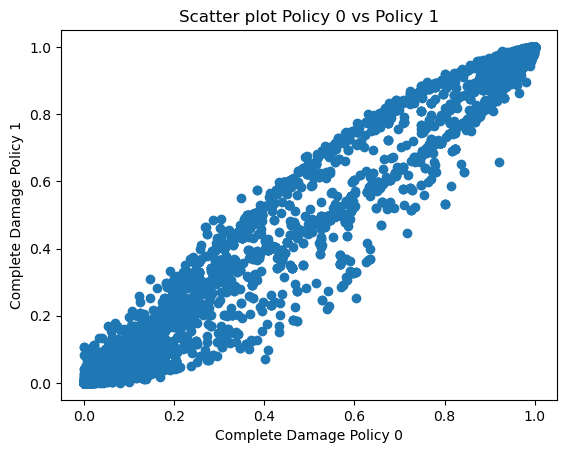

In [98]:
import matplotlib.pyplot as plt
# Scatter Plot
plt.scatter(bdmg_df_policies['DS_3_policy0'], bdmg_df_policies[f'DS_3_policy{i}'])
plt.title(f'Scatter plot Policy 0 vs Policy {i}')
plt.xlabel('Complete Damage Policy 0')
plt.ylabel(f'Complete Damage Policy {i}')
plt.savefig(f'CompleteDamage{i}.tif', dpi = 200)
plt.show()

## Postprocessing: Recovery

In [99]:
df_hhrs_policy2 = pd.read_csv (f"df_hhrs_results_policy_{i}.csv")
# merge household unit information with recovery results
pd_df_hs_policy2 = pd.merge(left = pd_df_policy2, 
                    right = df_hhrs_policy2,
                    left_on=['guid','huid'],
                    right_on=['guid','huid'],
                    how='left')
pd_df_hs_policy2[['guid','huid']].describe()

,guid,huid
count,131987,131987
unique,104607,131987
top,6396008f-530a-481c-9757-93f7d58391f9,B481677201001000H222
freq,293,1


## 6a) Sufficient Quality Solutions Found?

In [100]:
pd_df_policy2 = pd.read_csv(f'pd_df_results_policy_{i}.csv')
df_hhrs_policy2 = pd.read_csv(f'df_hhrs_results_policy_{i}.csv')

pd_df_hs_policy2 = pd.merge(left = pd_df_policy2, 
                    right = df_hhrs_policy2,
                    left_on=['guid','huid'],
                    right_on=['guid','huid'],
                    how='left')

In [101]:
# Add HHRS categories to dataframe
pd_df_hs_policy2 = add_label_cat_values_df(pd_df_hs_policy2, 
            valuelabels = hhrs_valuelabels, variable = '13')
pd_df_hs_policy2 = add_label_cat_values_df(pd_df_hs_policy2, 
            valuelabels = permanenthousing_valuelabels,
                        variable = '13')

In [102]:
poptable.pop_results_table(pd_df_hs_policy2, 
                  who = "Total Population by Householder", 
                  what = "by Permanent Housing at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010 - Policy 2 - All buildings elvated",
                  row_index = 'Race Ethnicity',
                  col_index = 'Permanent Housing',
                  row_percent = '0 Not Permanent Housing'
                  )

Permanent Housing,0 Not Permanent Housing (%),1 Permanent Housing (%),Total Population by Householder (%),Percent Row 0 Not Permanent Housing
Race Ethnicity,,,,
"1 White alone, Not Hispanic","1,442 (58.7%)","35,944 (60.8%)","37,386 (60.7%)",3.9%
"2 Black alone, Not Hispanic",376 (15.3%),"10,202 (17.3%)","10,578 (17.2%)",3.6%
"3 American Indian and Alaska Native alone, Not Hispanic",14 (0.6%),242 (0.4%),256 (0.4%),5.5%
"4 Asian alone, Not Hispanic",69 (2.8%),"1,167 (2.0%)","1,236 (2.0%)",5.6%
"5 Other Race, Not Hispanic",18 (0.7%),593 (1.0%),611 (1.0%),2.9%
"6 Any Race, Hispanic",536 (21.8%),"10,933 (18.5%)","11,469 (18.6%)",4.7%
7 Group Quarters no Race Ethnicity Data,nan (nan%),48 (0.1%),48 (0.1%),nan%
Total,"2,455 (100.0%)","59,129 (100.0%)","61,584 (100.0%)",4.0%


In [103]:
poptable.pop_results_table(pd_df_hs, 
                  who = "Total Population by Householder", 
                  what = "by Permanent Housing at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010 - Baseline",
                  row_index = 'Race Ethnicity',
                  col_index = 'Permanent Housing',
                  row_percent = '0 Not Permanent Housing'
                  )

Permanent Housing,0 Not Permanent Housing (%),1 Permanent Housing (%),Total Population by Householder (%),Percent Row 0 Not Permanent Housing
Race Ethnicity,,,,
"1 White alone, Not Hispanic","1,046 (51.5%)","8,572 (52.3%)","9,618 (52.2%)",10.9%
"2 Black alone, Not Hispanic",376 (18.5%),"2,799 (17.1%)","3,175 (17.2%)",11.8%
"3 American Indian and Alaska Native alone, Not Hispanic",11 (0.5%),68 (0.4%),79 (0.4%),13.9%
"4 Asian alone, Not Hispanic",63 (3.1%),566 (3.5%),629 (3.4%),10.0%
"5 Other Race, Not Hispanic",14 (0.7%),202 (1.2%),216 (1.2%),6.5%
"6 Any Race, Hispanic",521 (25.7%),"4,153 (25.3%)","4,674 (25.4%)",11.1%
7 Group Quarters no Race Ethnicity Data,nan (nan%),26 (0.2%),26 (0.1%),nan%
Total,"2,031 (100.0%)","16,386 (100.0%)","18,417 (100.0%)",11.0%
